#    Zillow Logerror Estimation Model


## Project Goals
1. create a model that can predict error in Zestimated values

2. from that model, identify key features driving logerror

3. clearly communicate finding to classmates

## Project Requirements
1. utilize clustering algorithms at some point in the pipeline

2. utilize statistical testing to identify key features

3. provide helpful visulatizations explaining exploration process

4. use scaling methods on data and document why they we're used

5. impute missing values and document

6. encode cateorical data

7. feature engineering and document rational behind it


### 0. Imports

In [163]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

#python libraries used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

#sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

#project specific functions
import acquire
import summarize
import prepare
import explore
import modeling
import cluster
from env import host,password,user



### I. Acquisition

Get data on homes sold in 2017 with recorded Latitude and Longitude

In [4]:
# #mysql query
# query = '''
#     SELECT prop.*, pred.logerror, pred.transactiondate
#     FROM predictions_2017 AS pred
#     LEFT JOIN properties_2017 AS prop  USING(parcelid)
#     WHERE (bedroomcnt > 0 AND bathroomcnt > 0 AND calculatedfinishedsquarefeet > 500 AND latitude IS NOT NULL AND longitude IS NOT NULL) 
#     AND (unitcnt = 1 OR unitcnt IS NULL)
#     ;
#     '''
# db_name = 'zillow'
# #get data from database
# zillow = pd.read_sql(query, f"mysql+pymysql://{user}:{password}@{host}/{db_name}")
# print(f'Data frame shape:\nrows: {zillow.shape[0]}\ncolumns: {zillow.shape[1]}')

In [5]:
zillow = pd.read_csv('data.csv')

## II. Preparation

Standardize all null values to *np.nan*

In [6]:
zillow.fillna(value=pd.np.nan, inplace=True)

Add some features I think will be significant

In [7]:
zillow['has_basement'] = zillow.basementsqft > 0
zillow['has_fireplace'] = zillow.fireplacecnt > 0
zillow['has_deck'] = ~zillow.decktypeid.isna()
zillow['has_garage'] = zillow.garagetotalsqft > 0
zillow['has_pool_or_spa'] = (zillow.hashottuborspa == 1) | (zillow.poolcnt> 0)
zillow['has_yardbuilding'] = (zillow.yardbuildingsqft17) > 0 | (zillow.yardbuildingsqft26 > 0)
zillow['multistory'] = zillow.numberofstories > 1
zillow['abs_logerror'] = zillow.logerror.apply(abs)

In [8]:
print(f'Data frame has:\nrows: {zillow.shape[0]}\ncolumns: {zillow.shape[1]}')

Data frame has:
rows: 73424
columns: 69


Drop columns that are missing over 25% of their data and rows that are missing over 60% 

In [9]:
zillow = prepare.handle_missing_values(zillow, prop_required_column= .25, prop_required_row=.60)
print(f'Data frame now has:\nrows: {zillow.shape[0]}\ncolumns: {zillow.shape[1]}')
print("No rows were dropped using this criteria.")

Data frame now has:
rows: 73424
columns: 44
No rows were dropped using this criteria.


Now we can clean up column names

In [10]:
zillow.rename(columns = {
    'parcelid': 'parcel_id',
    'airconditioningtypeid': 'ac_type_id',
    'bathroomcnt': 'bathroom_cnt',
    'bedroomcnt': 'bedroom_cnt',
    'buildingqualitytypeid': 'building_quality_type',
    'calculatedbathnbr': 'sum_bed_bath',
    'calculatedfinishedsquarefeet': 'square_feet',
    'fips': 'fips_code',
    'fullbathcnt': 'full_bath_cnt',
    'garagecarcnt': 'garage_car_cnt',
    'garagetotalsqft': 'garage_sqr_ft',
    'heatingorsystemtypeid': 'heating_type_id',
    'lotsizesquarefeet': 'lot_sqr_ft',
    'propertycountylandusecode': 'property_land_use_code',
    'propertylandusetypeid': 'property_land_use_id',
    'propertyzoningdesc': 'property_zoning',
    'rawcensustractandblock': 'raw_census_block',
    'regionidcity': 'city_id',
    'regionidcounty': 'county_id',
    'regionidneighborhood': 'neighborhood_id',
    'regionidzip': 'zipcode_id',
    'roomcnt': 'room_cnt',
    'unitcnt': 'unit_cnt',
    'yearbuilt': 'year_built',
    'structuretaxvaluedollarcnt': 'building_value',
    'taxvaluedollarcnt': 'total_value',
    'assessmentyear': 'year_assessed',
    'landtaxvaluedollarcnt': 'land_value',
    'taxamount': 'tax_amount',
    'censustractandblock': 'census_block',
    'transactiondate': 'transaction_date'
    }, inplace= True)
zillow.head()

,id,parcel_id,ac_type_id,bathroom_cnt,bedroom_cnt,building_quality_type,sum_bed_bath,square_feet,finishedsquarefeet12,fips_code,...,logerror,transaction_date,has_basement,has_fireplace,has_deck,has_garage,has_pool_or_spa,has_yardbuilding,multistory,abs_logerror
0,1727539,14297519,NaN,3.5,4.0,NaN,3.5,3100.0,3100.0,6059.0,...,0.025595,2017-01-01,False,False,False,True,False,False,False,0.025595
1,1387261,17052889,NaN,1.0,2.0,NaN,1.0,1465.0,1465.0,6111.0,...,0.055619,2017-01-01,False,True,False,False,False,False,False,0.055619
2,11677,14186244,NaN,2.0,3.0,NaN,2.0,1243.0,1243.0,6059.0,...,0.005383,2017-01-01,False,False,False,True,True,False,False,0.005383
3,2288172,12177905,NaN,3.0,4.0,8.0,3.0,2376.0,2376.0,6037.0,...,-0.103410,2017-01-01,False,False,False,False,True,False,False,0.103410
4,1970746,10887214,1.0,3.0,3.0,8.0,3.0,1312.0,1312.0,6037.0,...,0.006940,2017-01-01,False,False,False,False,True,False,False,0.006940


### Dataframe Cleaning
- drop redundant columns
     
- drop columns with no variance (single values columns)
- change build year measure to house age and drop year_built
- divide latitude and longitude by a factor of 6
- dropping building quality type because it has no reference
- impute missing values

**Redundant Columns**
1. raw_census_block and census_block hold the same information
2. county_id and fips_id hold the same information
3. garage_car_cnt and garage_sqr_ft are replaced with has_garage     

In [11]:
zillow.drop(columns = 'raw_census_block', inplace= True)
zillow.drop(columns = 'county_id', inplace= True)
zillow.drop(columns = ['garage_sqr_ft', 'garage_car_cnt'], inplace= True)

**Columns with no Variance**
- unit_cnt and year_assessed
    

In [12]:
zillow.drop(columns = ['year_assessed', 'unit_cnt'], inplace= True)

**Are Room Count and Sum Bath and Bed Valid Columns?**
- Room count should be at least bedroom + bathroom count

In [13]:
invalid_rows = ((zillow.bedroom_cnt + zillow.bathroom_cnt) > zillow.room_cnt).sum()
print(f'There are {invalid_rows} invalid room counts')
invalid_rows = ((zillow.bedroom_cnt + zillow.bathroom_cnt) > zillow.sum_bed_bath).sum()
print(f'There are {invalid_rows} invalid sum bed and bath counts')

There are 57199 invalid room counts
There are 73409 invalid sum bed and bath counts


- We're going to drop that row and re-compute a better one


In [14]:
zillow.drop(columns = ['room_cnt','sum_bed_bath'], inplace= True)
zillow['bed_bath_cnt'] = round(zillow.bedroom_cnt + zillow.bathroom_cnt)

**Edit Columns**
- Build year can be scaled reasonably by computing house age from date of assesment and replacing

In [15]:
zillow['home_age'] = 2016 - zillow.year_built
zillow.drop(columns = 'year_built', inplace= True)

- Latitude and Longitude should be more useful for plotting if we shorten them.

In [16]:
zillow['latitude'] = zillow.latitude/(10^6)
zillow['longitude'] = zillow.longitude/(10^6)

- building quality type is getting dropped because it's meaning isn't listed anywhere

In [17]:
zillow.drop(columns = 'building_quality_type', inplace=True)

**impute missing values**
- If a column has > 1,000 missing values, we'll consider imputing
- If a column has too many unique values and too many missing rows, we'll drop it

In [18]:
summarize.nulls_by_col(zillow).sort_values('num_rows_missing', ascending= False).head(6)

,num_rows_missing,pct_rows_missing
ac_type_id,48878,0.665695
neighborhood_id,44755,0.609542
property_zoning,26517,0.361149
heating_type_id,25224,0.343539
lot_sqr_ft,8067,0.109869
city_id,1437,0.019571


- Looking at the top rows nuniques:

In [19]:
cols = ['ac_type_id', 'neighborhood_id', 'property_zoning', 'heating_type_id', 'lot_sqr_ft', 'city_id']
pd.DataFrame(zillow[cols].nunique(), columns=['n_uniques'])

,n_uniques
ac_type_id,5
neighborhood_id,477
property_zoning,1849
heating_type_id,10
lot_sqr_ft,18528
city_id,175


- So Lets looks if there's a reasonable mode for ac_type and heating_type

In [20]:
#ac_type
pd.DataFrame(zillow.ac_type_id.value_counts()).rename(columns = {'ac_type_id': 'count'})

,count
1.0,22758
13.0,1567
5.0,167
11.0,53
9.0,1


In [21]:
#Heating_type
pd.DataFrame(zillow.heating_type_id.value_counts()).rename(columns = {'heating_type_id': 'count'})

,count
2.0,33196
7.0,13192
24.0,836
6.0,773
20.0,104
13.0,59
18.0,23
1.0,13
10.0,3
11.0,1


- And, since 93% of ac type are one value and 73% of heating are on value, we'll impute those columns with their modes

In [22]:
mode_imputer = SimpleImputer(strategy= 'most_frequent')
zillow[['ac_type_id', 'heating_type_id']] = mode_imputer.fit_transform(zillow[['ac_type_id', 'heating_type_id']])

- lot_square_feet is a float value and can be imputed on median

In [23]:
med_imputer = SimpleImputer(strategy= 'median')
zillow[['lot_sqr_ft']] = med_imputer.fit_transform(zillow[['lot_sqr_ft']])

- neighborhood_id, property_zoning, and city_id have too many unique values to comfortable impute and will be droped

In [24]:
zillow.drop(columns=['neighborhood_id', 'property_zoning', 'city_id'], inplace= True)

- and we'll drop remaining null rows

In [25]:
zillow.dropna(inplace=True)

zillow is now a cleaned of all nulls

In [26]:
summarize.nulls_by_col(zillow)

,num_rows_missing,pct_rows_missing
id,0,0.0
parcel_id,0,0.0
ac_type_id,0,0.0
bathroom_cnt,0,0.0
bedroom_cnt,0,0.0
square_feet,0,0.0
finishedsquarefeet12,0,0.0
fips_code,0,0.0
full_bath_cnt,0,0.0
heating_type_id,0,0.0


## III. Exploration

Which features have a significant impact on error?

- house age

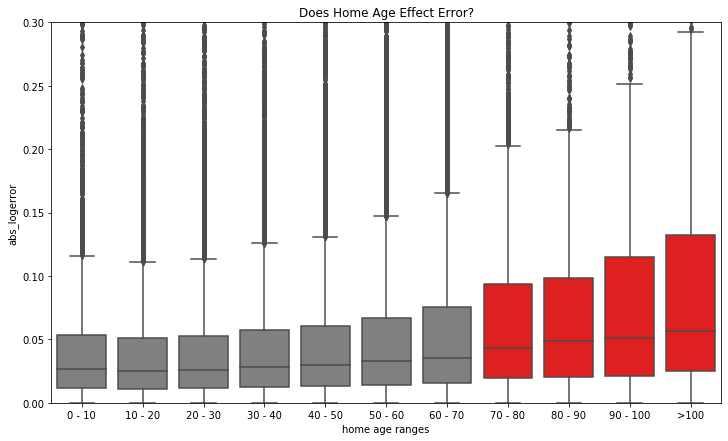

In [27]:
bins = [0,10,20,30,40,50,60,70,80,90,100, 1000]
zillow['home_age_bins']=pd.cut(zillow.home_age, bins = bins)

plt.figure(figsize= (12,7))
sns.boxplot(y = 'abs_logerror', data = zillow ,x = 'home_age_bins', palette=['grey']*7+['red']*4)
plt.ylim(0, .3)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10],["0 - 10","10 - 20","20 - 30","30 - 40","40 - 50","50 - 60","60 - 70","70 - 80","80 - 90","90 - 100",">100"])
plt.title('Does Home Age Effect Error?')
plt.xlabel('home age ranges')
plt.show()

- county

Text(0.5, 0, 'county')

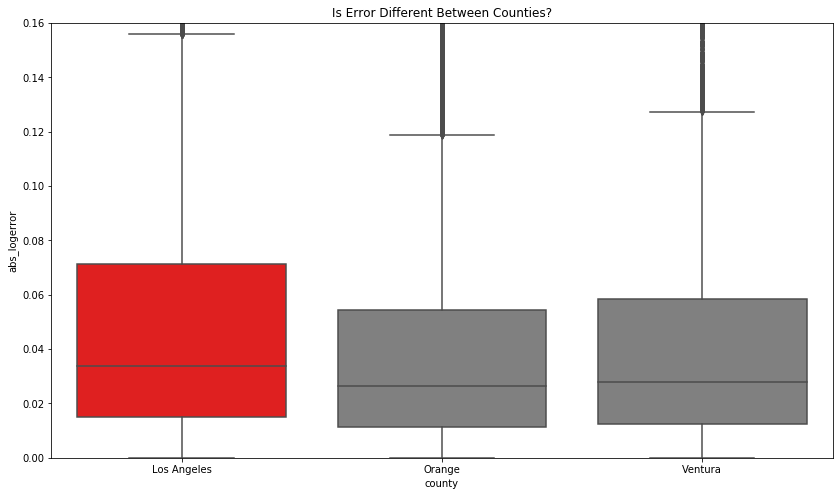

In [28]:
plt.figure(figsize=(14,8))
sns.boxplot(x = 'fips_code', y = 'abs_logerror', data = zillow, palette=['red','grey','grey'])
plt.xticks([0,1,2], ['Los Angeles', 'Orange','Ventura'])
plt.ylim(0, .16)
plt.title('Is Error Different Between Counties?')
plt.xlabel('county')

- Room Count

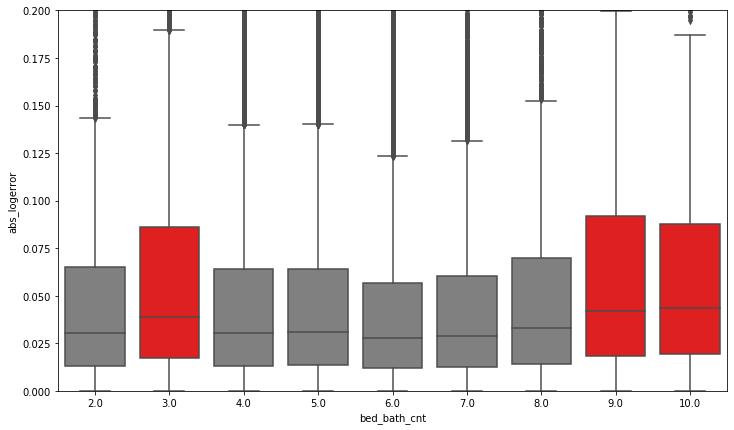

2.0      2678
3.0      6281
4.0     14863
5.0     17320
6.0     17551
7.0      7112
8.0      4077
9.0      1184
10.0     1167
11.0      316
12.0      190
13.0       67
14.0       43
15.0       19
16.0       11
17.0        6
18.0        2
19.0        1
20.0        2
21.0        1
Name: bed_bath_cnt, dtype: int64

In [29]:
plt.figure(figsize= (12,7))
sns.boxplot(y = 'abs_logerror', data = zillow[zillow.bed_bath_cnt <= 10] ,x = 'bed_bath_cnt', palette=['grey']+['red']+['grey']*5+['red']*2)
plt.ylim(0, .2)
plt.show()
zillow.bed_bath_cnt.value_counts().sort_index()

Values > 10 have too few rows to make a strong implication

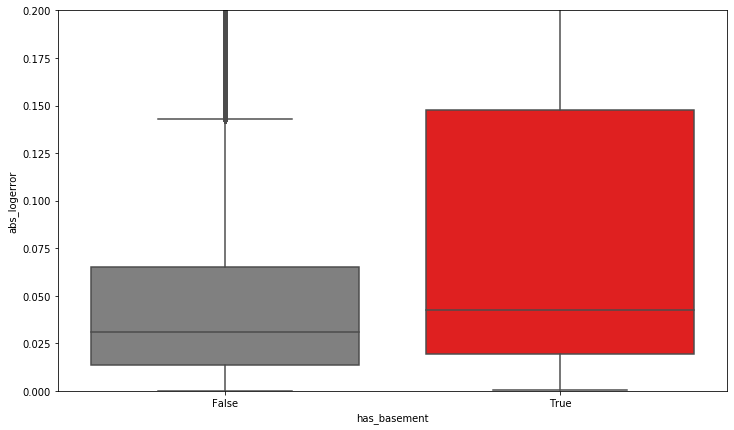

False    72841
True        50
Name: has_basement, dtype: int64

In [30]:
plt.figure(figsize= (12,7))
sns.boxplot(y = 'abs_logerror', data = zillow ,x = 'has_basement', palette=['grey']+['red']+['grey']*5+['red']*2)
plt.ylim(0, .2)
plt.show()
zillow.has_basement.value_counts().sort_index()

### Clusters

Removing the geographic fields, the transaction_date, id numbers, and full_bath_cnt.

In [31]:
lat_long = zillow[['latitude','longitude']]
fips_code = zillow['fips_code']
log_error = zillow['logerror']

In [32]:
zillow2 = zillow.drop(['transaction_date',
              'property_land_use_code', 
              'id', 
              'parcel_id',
              'zipcode_id',
              'fips_code',
              'census_block',
              'finishedsquarefeet12',
              'full_bath_cnt',
              'latitude',
              'longitude',
              'logerror',
              'abs_logerror',
              'home_age_bins'], axis=1)

In [33]:
zillow2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72891 entries, 0 to 73423
Data columns (total 20 columns):
ac_type_id              72891 non-null float64
bathroom_cnt            72891 non-null float64
bedroom_cnt             72891 non-null float64
square_feet             72891 non-null float64
heating_type_id         72891 non-null float64
lot_sqr_ft              72891 non-null float64
property_land_use_id    72891 non-null float64
building_value          72891 non-null float64
total_value             72891 non-null float64
land_value              72891 non-null float64
tax_amount              72891 non-null float64
has_basement            72891 non-null bool
has_fireplace           72891 non-null bool
has_deck                72891 non-null bool
has_garage              72891 non-null bool
has_pool_or_spa         72891 non-null bool
has_yardbuilding        72891 non-null bool
multistory              72891 non-null bool
bed_bath_cnt            72891 non-null float64
home_age           

Applying Standard Scaling to the features

In [34]:
df_standard, df2, std_object = cluster.standardize_train_test(zillow2, zillow2)
#The std_object will be used later to un-scale the data for human observation

In [35]:
df_standard.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72891 entries, 0 to 73423
Data columns (total 20 columns):
ac_type_id              72891 non-null float64
bathroom_cnt            72891 non-null float64
bedroom_cnt             72891 non-null float64
square_feet             72891 non-null float64
heating_type_id         72891 non-null float64
lot_sqr_ft              72891 non-null float64
property_land_use_id    72891 non-null float64
building_value          72891 non-null float64
total_value             72891 non-null float64
land_value              72891 non-null float64
tax_amount              72891 non-null float64
has_basement            72891 non-null float64
has_fireplace           72891 non-null float64
has_deck                72891 non-null float64
has_garage              72891 non-null float64
has_pool_or_spa         72891 non-null float64
has_yardbuilding        72891 non-null float64
multistory              72891 non-null float64
bed_bath_cnt            72891 non-null float6

### Evaluating the inertia values for up to 9 clusters.

In [36]:
cluster.list_inertia_scores(df_standard)

1 : 3.684754930224812
2 : 3.3651457693958395
3 : 3.228931976539592
4 : 3.0789050820375823
5 : 2.842301444073434
6 : 2.8204505294607425
7 : 2.759368186786417
8 : 2.665396918260715
9 : 2.5828605925689017


It's a toss-up between 2 or 3 clusters

## Clustering
#### 2 Clusters

In [37]:
two_cluster_df = cluster.make_clusters(df_standard, n_clusters=2)

Looks like a lopsided clustering. 75/25 split.

In [38]:
two_cluster_df['cluster_labels'].value_counts()

0    53809
1    19082
Name: cluster_labels, dtype: int64

In [39]:
54660/72891

0.7498868173025477

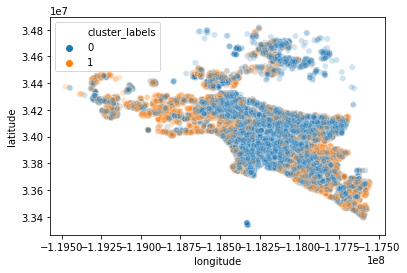

In [40]:
cluster.show_clusters_on_map(two_cluster_df)

### Cluster #1 kinda predicts LA County

The Lat-Long and the Cluser Labels will be dropped to match the scaling object created when the feature matrix was scaled

In [41]:
cluster_labels = two_cluster_df.cluster_labels
two_cluster_df.drop('cluster_labels',axis=1,inplace=True)
two_cluster_df.drop(['latitude','longitude'],axis=1,inplace=True)

The dataframe is unscaled for human readibility when comparing the two clusters

In [42]:
scaler, unscaled_df = cluster.my_inv_transform(std_object, two_cluster_df)

Labels are re-attached

In [43]:
unscaled_df['cluster_labels'] = cluster_labels

In [44]:
unscaled_df['logerror'] = log_error

### EXPLORE THOSE CLUSTERS

Breakdown of mean values for all fields of each cluster.

In [45]:
unscaled_df.groupby('cluster_labels').mean()

,ac_type_id,bathroom_cnt,bedroom_cnt,square_feet,heating_type_id,lot_sqr_ft,property_land_use_id,building_value,total_value,land_value,...,has_basement,has_fireplace,has_deck,has_garage,has_pool_or_spa,has_yardbuilding,multistory,bed_bath_cnt,home_age,logerror
cluster_labels,,,,,,,,,,,,,,,,,,,,,
0,1.091286,1.962897,2.681838,1392.229924,3.611608,33428.265811,262.917913,127161.004497,332179.324797,205018.320300,...,0.000316,0.045253,0.002936,0.127116,0.164118,0.013455,0.032931,4.650040,49.744448,0.014243
1,1.787444,3.217299,4.009485,2809.514097,2.161985,13869.351064,261.418457,365131.140342,927131.529137,562000.388796,...,0.001729,0.301960,0.023268,0.568756,0.396080,0.085106,0.271198,7.230741,36.038308,0.023285


The logerror for all observations

In [46]:
unscaled_df.logerror.mean()

0.016609865210700406

The logerror for each cluster

In [47]:
unscaled_df.groupby('cluster_labels').logerror.mean()

cluster_labels
0    0.014243
1    0.023285
Name: logerror, dtype: float64

Re-attaching the fips_code to see how the clusters fit in the city codes.

In [48]:
unscaled_df['fips_code'] = fips_code

In [49]:
fips_code.value_counts()

6037.0    46910
6059.0    19951
6111.0     6030
Name: fips_code, dtype: int64

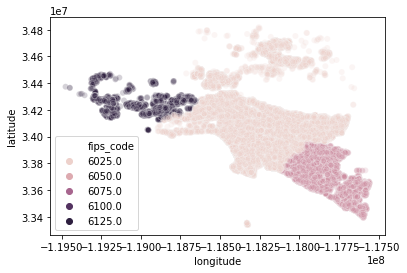

In [50]:
cluster.show_clusters_on_map(unscaled_df, cluster_label='fips_code')

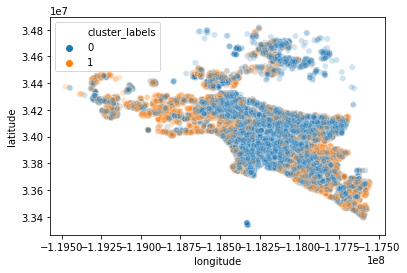

In [51]:
cluster.show_clusters_on_map(unscaled_df, cluster_label='cluster_labels')

In [52]:
big_cluster = unscaled_df[unscaled_df.cluster_labels == 0]

In [53]:
lil_cluster = unscaled_df[unscaled_df.cluster_labels == 1]

In [54]:
stats.ttest_1samp(big_cluster.logerror, unscaled_df.logerror.mean())

Ttest_1sampResult(statistic=-3.5256766521675367, pvalue=0.000422753316334858)

In [55]:
stats.ttest_1samp(lil_cluster.logerror, unscaled_df.logerror.mean())

Ttest_1sampResult(statistic=5.084279437393194, pvalue=3.7251473051329794e-07)

## UNSCALED DF is ZILLOW, but with Cluster Labels (0,1)

In [56]:
export_csv = unscaled_df.to_csv ('labeled_data.csv', index = None, header=True)

## IV. Feature Engineering

**Get Data**

In [57]:
model_zillow = pd.read_csv('labeled_data.csv')

- are features distributed well among categorical permits

In [58]:
print('**************')
for i in model_zillow.columns.tolist():
    if model_zillow[i].nunique() < 11:
        print(i)
        for j in model_zillow[i].unique().tolist():
            count = model_zillow[model_zillow[i] == j][i].count()
            print(f'{j}: {count}')
        print('**************')
        

**************
ac_type_id
1.0: 71110
13.0: 1562
5.0: 166
11.0: 53
**************
heating_type_id
2.0: 57955
7.0: 13141
6.0: 770
24.0: 830
13.0: 59
17.999999999999996: 23
20.0: 96
1.0: 13
10.0: 3
11.0: 1
**************
property_land_use_id
261.0: 51717
266.0: 18799
269.0: 1933
265.0: 333
267.0: 26
260.0: 8
263.0: 59
275.0: 9
264.0: 6
246.0: 1
**************
has_basement
0.0: 72841
1.0: 50
**************
has_fireplace
0.0: 64694
1.0: 8197
**************
has_deck
0.0: 72289
1.0: 602
**************
has_garage
1.0: 17693
0.0: 55198
**************
has_pool_or_spa
0.0: 56502
1.0: 16389
**************
has_yardbuilding
0.0: 70543
1.0: 2348
**************
multistory
0.0: 65944
1.0: 6947
**************
cluster_labels
1: 19082
0: 53809
**************
fips_code
6059.0: 19951
6111.0: 6030
6037.0: 46910
**************


Drop columns with values of < 1000

In [59]:
model_zillow.drop(columns = ['ac_type_id', 'has_basement', 'has_deck', 'heating_type_id', 'property_land_use_id'], inplace = True)

- do columns have a significant impact on logerror?

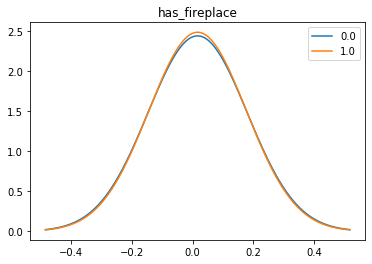

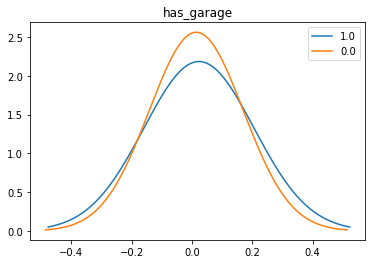

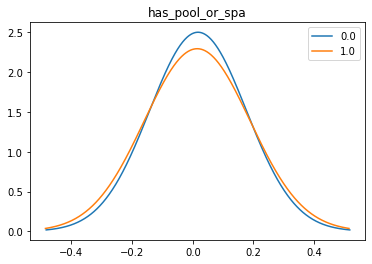

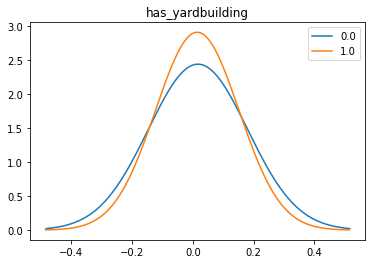

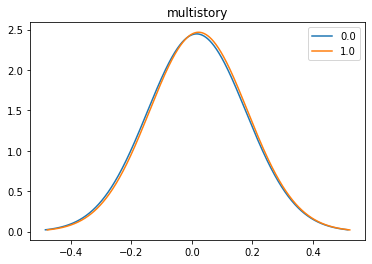

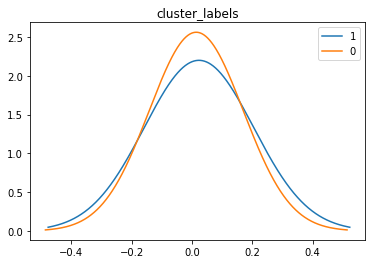

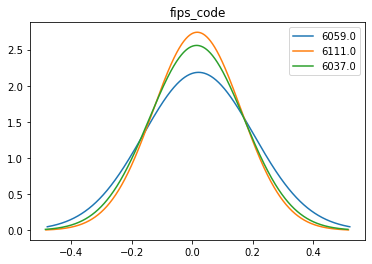

In [60]:
explore.compare_standard_curves(model_zillow)

T Tests

In [61]:
for i in model_zillow.drop(columns = 'cluster_labels').columns.to_list():
    if model_zillow[i].nunique() == 2:
        true = model_zillow[model_zillow[i] == True].logerror
        false = model_zillow[model_zillow[i] == False].logerror
        print(f'{i} T Test\n'+
              f'true mean: {true.mean()}, false mean: {false.mean()}')
        print(stats.ttest_ind(true,false), '\n')

has_fireplace T Test
true mean: 0.016681856916856364, false mean: 0.0166007435608511
Ttest_indResult(statistic=0.042474360523316566, pvalue=0.9661206669799932) 

has_garage T Test
true mean: 0.02341574630711503, false mean: 0.014428328665193828
Ttest_indResult(statistic=6.388426288037615, pvalue=1.686081449116655e-10) 

has_pool_or_spa T Test
true mean: 0.014584876602157142, false mean: 0.017197234477370867
Ttest_indResult(statistic=-1.8076966311038567, pvalue=0.07065784979842524) 

has_yardbuilding T Test
true mean: 0.014349997568380473, false mean: 0.016685084144176066
Ttest_indResult(statistic=-0.6833691841303775, pvalue=0.4943757594078849) 

multistory T Test
true mean: 0.02230140766531738, false mean: 0.016010278509374733
Ttest_indResult(statistic=3.0620891428586745, pvalue=0.0021987801750160386) 



In [62]:
model_zillow.drop(columns = ['has_fireplace', 'has_pool_or_spa', 'has_yardbuilding'], inplace = True)

- Add absolute value of logerror as new target to explore

In [63]:
model_zillow['abs_logerror'] = model_zillow.logerror.apply(abs)

**Scaling**
- How shoud we scale each column?

In [64]:
model_zillow.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
bathroom_cnt,72891.0,2.291284e+00,0.942480,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.300000e+01
bedroom_cnt,72891.0,3.029400e+00,0.998352,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.100000e+01
square_feet,72891.0,1.763258e+03,926.371980,5.010000e+02,1.176000e+03,1.525000e+03,2.076000e+03,2.192900e+04
lot_sqr_ft,72891.0,2.830797e+04,119319.392449,2.360000e+02,5.994000e+03,7.266000e+03,1.080300e+04,6.971010e+06
building_value,72891.0,1.894588e+05,225478.767841,4.400000e+01,8.488200e+04,1.368440e+05,2.183810e+05,9.164901e+06
total_value,72891.0,4.879308e+05,624247.033343,3.254000e+03,2.072385e+05,3.590000e+05,5.670655e+05,2.538125e+07
land_value,72891.0,2.984720e+05,453747.436811,1.610000e+02,8.485400e+04,2.036000e+05,3.659740e+05,2.233550e+07
tax_amount,72891.0,5.956081e+03,7254.652895,1.992000e+01,2.714935e+03,4.437790e+03,6.883875e+03,2.909981e+05
has_garage,72891.0,2.427323e-01,0.428738,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
multistory,72891.0,9.530669e-02,0.293640,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


- Standard Scaler

In [65]:
features = ['square_feet', 'lot_sqr_ft', 'building_value', 'total_value', 'land_value', 'tax_amount', 'latitude', 'longitude']
model_zillow[features] = StandardScaler().fit_transform(model_zillow[features])

- Min-Max Scaler

In [66]:
features = ['bed_bath_cnt', 'bathroom_cnt', 'bedroom_cnt', 'home_age']
model_zillow[features] = MinMaxScaler().fit_transform(model_zillow[features])

**One Hot Encode County**

In [67]:
model_zillow[['los_angeles','orange','ventura']] = pd.get_dummies(model_zillow.fips_code)
model_zillow.drop(columns = 'fips_code', inplace=True)

## V. Modeling

**Add Baseline**

In [73]:
model_zillow['abs_baseline'] = model_zillow.abs_logerror.mean()
model_zillow['log_baseline'] = model_zillow.logerror.mean()

**Split data**

In [132]:
train, test = train_test_split(model_zillow, random_state = 123, train_size = .8, stratify = model_zillow.cluster_labels)

**Minimum Viable Product**

- Linear Regression

In [133]:
features = ['building_value', 'home_age', 'latitude', 'longitude']
regr = LinearRegression()
regr.fit(train[features], train.abs_logerror)
yhat = regr.predict(train[features])

In [134]:
rmse_baseline = (mean_squared_error(train.abs_baseline, train.abs_logerror))**.5
rmse_model = (mean_squared_error(yhat, train.abs_logerror))**.5
print(f'Baseline error: {rmse_baseline}')
print(f'Model error: {rmse_model}')

Baseline error: 0.1476383303435314
Model error: 0.14664314812840737


**Model (Without Clusters)** 
- Linear Regression

In [135]:
features = ['tax_amount', 'home_age', 'latitude', 'longitude', 'los_angeles', 'orange', 'ventura', 'bed_bath_cnt', 'multistory', 'has_garage', 'square_feet', 'lot_sqr_ft']
regr = LinearRegression()
regr.fit(train[features], train.abs_logerror)
yhat = regr.predict(train[features])

In [136]:
rmse_baseline = (mean_squared_error(train.abs_baseline, train.abs_logerror))**.5
rmse_model = (mean_squared_error(yhat, train.abs_logerror))**.5
print(f'Baseline error: {rmse_baseline}')
print(f'Model error: {rmse_model}')

Baseline error: 0.1476383303435314
Model error: 0.14633436429907112


- Decision Tree

In [153]:
tree = DecisionTreeRegressor(max_depth = 4, random_state=123)
tree.fit(train[features], train.abs_logerror)
yhat = tree.predict(train[features])

In [154]:
rmse_baseline = (mean_squared_error(train.abs_baseline, train.abs_logerror))**.5
rmse_model = (mean_squared_error(yhat, train.abs_logerror))**.5
print(f'Baseline error: {rmse_baseline}')
print(f'Model error: {rmse_model}')

Baseline error: 0.1476383303435314
Model error: 0.14538593688770904


- Lasso

In [165]:
lasso = LassoCV()
lasso.fit(train[features], train.abs_logerror)
yhat = lasso.predict(train[features])

In [166]:
rmse_baseline = (mean_squared_error(train.abs_baseline, train.abs_logerror))**.5
rmse_model = (mean_squared_error(yhat, train.abs_logerror))**.5
print(f'Baseline error: {rmse_baseline}')
print(f'Model error: {rmse_model}')

Baseline error: 0.1476383303435314
Model error: 0.14633449327012416


**Model (With Cluster)**
- Linear regression

In [167]:
features = ['latitude', 'longitude', 'cluster_labels', 'ventura', 'los_angeles', 'orange']
regr = LinearRegression()
regr.fit(train[features], train.abs_logerror)
yhat = regr.predict(train[features])

In [168]:
rmse_baseline = (mean_squared_error(train.abs_baseline, train.abs_logerror))**.5
rmse_model = (mean_squared_error(yhat, train.abs_logerror))**.5
print(f'Baseline error: {rmse_baseline}')
print(f'Model error: {rmse_model}')

Baseline error: 0.1476383303435314
Model error: 0.1474899271155652


- Decision Tree

In [169]:
tree = DecisionTreeRegressor(max_depth = 4, random_state=123)
tree.fit(train[features], train.abs_logerror)
yhat = tree.predict(train[features])

In [170]:
rmse_baseline = (mean_squared_error(train.abs_baseline, train.abs_logerror))**.5
rmse_model = (mean_squared_error(yhat, train.abs_logerror))**.5
print(f'Baseline error: {rmse_baseline}')
print(f'Model error: {rmse_model}')

Baseline error: 0.1476383303435314
Model error: 0.1466667060094108


- Lasso

In [173]:
lasso = LassoCV()
lasso.fit(train[features], train.abs_logerror)
yhat = lasso.predict(train[features])

In [174]:
rmse_baseline = (mean_squared_error(train.abs_baseline, train.abs_logerror))**.5
rmse_model = (mean_squared_error(yhat, train.abs_logerror))**.5
print(f'Baseline error: {rmse_baseline}')
print(f'Model error: {rmse_model}')

Baseline error: 0.1476383303435314
Model error: 0.14748992773255187


**Model Selection**

From the results, we're going to choose the decision tree model on unclustered data

In [175]:
features = ['tax_amount', 'home_age', 'latitude', 'longitude', 'los_angeles', 'orange', 'ventura', 'bed_bath_cnt', 'multistory', 'has_garage', 'square_feet', 'lot_sqr_ft']
tree = DecisionTreeRegressor(max_depth = 4, random_state=123)
tree.fit(train[features], train.abs_logerror)
yhat = tree.predict(test[features])

In [176]:
rmse_baseline = (mean_squared_error(test.abs_baseline, test.abs_logerror))**.5
rmse_model = (mean_squared_error(yhat, test.abs_logerror))**.5
print(f'Baseline error: {rmse_baseline}')
print(f'Model error: {rmse_model}')

Baseline error: 0.1580674979093418
Model error: 0.15775791984344018


- Key Features

In [186]:
important_features = tree.feature_importances_
pd.DataFrame(important_features, index = features, columns = ['feature_strength']).sort_values('feature_strength', ascending = False)

,feature_strength
home_age,0.418550
tax_amount,0.238289
latitude,0.162697
square_feet,0.107991
lot_sqr_ft,0.072473
longitude,0.000000
los_angeles,0.000000
orange,0.000000
ventura,0.000000
bed_bath_cnt,0.000000


In [187]:
model_zillow.columns.tolist()

['bathroom_cnt',
 'bedroom_cnt',
 'square_feet',
 'lot_sqr_ft',
 'building_value',
 'total_value',
 'land_value',
 'tax_amount',
 'has_garage',
 'multistory',
 'bed_bath_cnt',
 'home_age',
 'cluster_labels',
 'logerror',
 'latitude',
 'longitude',
 'abs_logerror',
 'los_angeles',
 'orange',
 'ventura',
 'abs_baseline',
 'log_baseline']